<a href="https://colab.research.google.com/github/dmamur/elembert/blob/noPosEmbeddings/elembert_classification_kfolds_LiCoMnO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def bert_module(query, key, value, i, config):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}_multiheadattention".format(i),
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=config.seed)
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu",kernel_initializer=tf.keras.initializers.GlorotUniform(seed=config.seed)),
            layers.Dense(config.EMBED_DIM,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=config.seed)),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs",
                                       embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=config.seed))(inputs)
    encoder_output = word_embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model


In [2]:
!git clone https://github.com/dmamur/elementsem.git
!pip install mp-api
!pip install ase

Cloning into 'elementsem'...
remote: Enumerating objects: 1562, done.
remote: Counting objects: 100% (644/644), done.
remote: Compressing objects: 100% (443/443), done.
remote: Total 1562 (delta 405), reused 339 (delta 195), pack-reused 918 (from 1)
Receiving objects: 100% (1562/1562), 131.79 MiB | 9.65 MiB/s, done.
Resolving deltas: 100% (864/864), done.
Updating files: 100% (365/365), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.9/211.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.2/122.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.8 MB/s eta 0:00:00
   ━━━━

# Data Generation

Get battery related crystals from Materials Project API https://next-gen.materialsproject.org/

In [3]:
from pymatgen.ext.matproj import MPRester

# Replace 'YOUR_API_KEY' with your actual Materials Project API key
api_key = "YOUR_API_KEY"

# Initialize MPRester with your API key
with MPRester(api_key) as mpr:
    # Query all materials with band gap = 0 (metallic)
    metallic_materials = mpr.summary.search(elements=['Co','Li','Mn','O'], fields=["material_id", "band_gap", "is_metal", "structure",'formula_pretty'])

    # Print the result for all metallic materials


<ipython-input-3-d42fac91011d>:9: DeprecationWarning: Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.
  metallic_materials = mpr.summary.search(elements=['Co','Li','Mn','O'], fields=["material_id", "band_gap", "is_metal", "symmetry", "is_stable",


Retrieving SummaryDoc documents:   0%|          | 0/1765 [00:00<?, ?it/s]

In [4]:
from ase.neighborlist import neighbor_list
from scipy.ndimage import gaussian_filter1d
from pymatgen.core import Lattice, Structure, Molecule
from ase.io import read, write
from joblib import dump, load
def getTypesXYZ(file):
    xyz=[]
    types=[]
    lattice=file['structure']['lattice']['matrix']
    for n in file['structure']['sites']:
        types.append(n['label'])
        xyz.append(n['xyz'])
    return types,lattice,np.asarray(xyz)

def getRawInputs(types,atoms,km):
    x= np.arange(0,10,0.1)
    v = np.concatenate([[1],4*np.pi/3*(x[1:]**3 - x[:-1]**3)])
    i, d = neighbor_list('id', atoms, 10.0, self_interaction=False)
    rdfatoms,ntypes=[],[]
    for k,l in enumerate(atoms):
        el=types[k]
        y = np.zeros(100)
        dist = np.round(d[i==k]*10)
        a,b=np.unique(dist, return_counts=True)
        np.put(y,a.astype(int)-1,b)
        values=gaussian_filter1d(y/v,1)
        num = km[el].predict(np.nan_to_num([values],nan=0,posinf=0, neginf=0))[0]
        ntypes.append(el+str(num))
        rdfatoms.append(values)
    return ntypes, np.asarray(rdfatoms)

ellst=open('/content/elementsem/models/pcakm/ellist.txt','r').read().split('\n')
print(ellst)

km = {i: load('/content/elementsem/models/kmeans/'+i+'_kmeans.pkl') for i in ellst}


['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Rn']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
import pandas as pd
# Create a dictionary to store the csv file
dfis = pd.DataFrame({
    'mpids': [i.material_id for  i in metallic_materials],
    'band_gap': [i.band_gap for  i in metallic_materials],
    'is_metal': [int(i.is_metal) for  i in metallic_materials],
    'formula_pretty': [i.formula_pretty for  i in metallic_materials],
    'structures': [i.structure for  i in metallic_materials],
})
dfis.to_csv('LiCoMnO_structures.csv')

### Get PDFs from structures

In [6]:
datpdfs,ids,bandgap,typesV0=[],[],[],[]
for i0,i in enumerate(metallic_materials):
    strct=i.structure.to_ase_atoms()
    _,pdfs = getRawInputs(strct.get_chemical_symbols(),strct,km)
    datpdfs.append(pdfs)
    typesV0.append(strct.get_chemical_symbols())
    bandgap.append(i.band_gap)
    ids.append(i.material_id)
    # Progress indicator
    if i0 % 100 == 0:
        print(f"Processed: {i0} documents")

Processed: 0 documents
Processed: 100 documents
Processed: 200 documents
Processed: 300 documents
Processed: 400 documents
Processed: 500 documents
Processed: 600 documents
Processed: 700 documents
Processed: 800 documents
Processed: 900 documents
Processed: 1000 documents
Processed: 1100 documents
Processed: 1200 documents
Processed: 1300 documents
Processed: 1400 documents
Processed: 1500 documents
Processed: 1600 documents
Processed: 1700 documents


### Refine kmean clusters for these elemenets

In [7]:
Lipdfs,Mnpdfs,Opdfs,Copdfs,=[],[],[],[]
for k,l in zip(datpdfs,typesV0):
    for k1,l1 in zip(k,l):
        if l1 == 'Li':
            Lipdfs.append(k1)
        elif l1 == 'Mn':
            Mnpdfs.append(k1)
        elif l1 == 'Co':
            Copdfs.append(k1)
        elif l1 == 'O':
            Opdfs.append(k1)

for i,j in zip(['Li','Mn','Co','O'],[Lipdfs,Mnpdfs,Copdfs,Opdfs]):
    #km[i] = KMeans(n_clusters=5, random_state=3425)
    km[i].fit(j)

### Get new sub-elements

In [8]:
datsub,datpdfs,ids,bandgap=[],[],[],[]
for i0,i in enumerate(metallic_materials):
    strct=i.structure.to_ase_atoms()
    tokens,pdfs = getRawInputs(strct.get_chemical_symbols(),strct,km)
    datsub.append(tokens)
    datpdfs.append(pdfs)
    bandgap.append(i.band_gap)
    ids.append(i.material_id)
    # Progress indicator
    if i0 % 100 == 0:
        print(f"Processed: {i0} documents")

Processed: 0 documents
Processed: 100 documents
Processed: 200 documents
Processed: 300 documents
Processed: 400 documents
Processed: 500 documents
Processed: 600 documents
Processed: 700 documents
Processed: 800 documents
Processed: 900 documents
Processed: 1000 documents
Processed: 1100 documents
Processed: 1200 documents
Processed: 1300 documents
Processed: 1400 documents
Processed: 1500 documents
Processed: 1600 documents
Processed: 1700 documents


### Write results to the csv file

In [9]:
dflimncoo = pd.DataFrame({
    'ids': ids,
    'typesV0': typesV0,
    'typesKm': datsub,
    'formula': [i.formula_pretty for  i in metallic_materials],
    'labels': np.asarray([1 if i == 0 else 0 for i in bandgap]),
})
df = dflimncoo.drop_duplicates(subset=['ids'], keep='first')
df.to_csv('LiCoMnO_ds.csv')

In [10]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembert_'
    MVER = 'Km'
    DSPATH="/content/elementsem/data/"
    PREPATH="/content/elementsem/models/pretrained/"
    PATH="/content/elementsem/models/"
config = Config()
seed=12345
tf.random.set_seed(seed)
np.random.seed(seed)

# Load vocabulary and types

In [11]:
mname=config.PATH+config.MNAME+'_%s_E_%s_H_%s_L_%s' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS)
df = pd.read_csv('LiCoMnO_ds.csv')
types = df['typesKm'].apply(eval).apply(list)
types_ = df['typesV0'].apply(eval).apply(list)
labels  = to_categorical(np.asarray(df['labels']))
uniquelbls=len(np.unique(np.asarray(df['labels'])))

with open(config.PREPATH+'/el2idV0.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
next_id = len(el2id)
# Iterate over the dictionaries and update el2id in one pass
for sent in types:
    for key in sent:
        if key not in element2id:
            element2id[key] = next_id
            next_id += 1

config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


vocabSize:  152


# Convert types to integers

In [12]:
#[random.shuffle(types[i]) for i in range(len(types))]
types0=[['[CLS]']+i+['[SEP]'] for i in types]
types0_=[['[CLS]']+i+['[SEP]'] for i in types_]
typesNumerical,typesNumerical_=[],[]
for i,j in zip(types0,types0_):
    typesNumerical.append([element2id[k] for k in i])
    typesNumerical_.append([element2id[k] for k in j])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)
x3_ = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical_,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

#z = load_model(config.PREPATH+'/elembert_%s_E_%s_H_%s_L_%s.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z.trainable = True

inputC = Input((config.MAX_LEN,), dtype=tf.int32,name='types')


In [13]:
def scheduler(epoch):
    initial_lrate = config.LR
    drop = 0.92
    epochs_drop = 10
    lr = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    if lr<0.0001:
        lr = 0.0001
    return lr


epochs=2*config.BATCH_SIZE

print('dataLen: ',x3.shape,labels.shape)

dataLen:  (1385, 128) (1385, 2)


In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# Assuming you have loaded your data into x3 and labels variables

# Define the number of folds
num_folds = 5

# Initialize Stratified K-Fold Cross-Validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store results
all_histories = []
all_reports = []
randseed = np.asarray([38005, 26930, 57873, 37766, 62593])
# Iterate over folds
m = tf.keras.metrics.AUC()
for fold, (train_idx, val_idx) in enumerate(kfold.split(x3, np.argmax(labels, axis=1))):
    print(f"\nTraining on Fold {fold + 1}...")
    config.seed = int(randseed[fold])
    z = create_elembert_model(inputC,config)
    e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
    f = Dense(uniquelbls, activation="softmax",name='out_tox',kernel_initializer=tf.keras.initializers.GlorotUniform(config.seed))(e)
    # Create and compile the model (assuming create_elembert_model function is available)
    model = Model(inputs=z.input, outputs=f)

    optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Extract training and validation sets
    x_train, x_val = x3[train_idx], x3[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    # Train the model
    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=config.BATCH_SIZE,
        verbose=0,
        callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)
    )

    # Evaluate the model on the validation set
    val_predictions = model.predict(x_val, batch_size=config.BATCH_SIZE)
    y_pclasses=np.argmax(val_predictions, axis=1)
    y_classes=np.argmax(y_val, axis=1)
    m.update_state(y_val, val_predictions)
    print('Km binary acc:',np.sum(y_pclasses==y_classes)/len(y_pclasses),'AUC:',m.result().numpy())
    val_predictions_ = model.predict(x3_, batch_size=config.BATCH_SIZE)
    y_pclasses=np.argmax(val_predictions_, axis=1)
    y_classes=np.argmax(labels, axis=1)
    m.update_state(labels, val_predictions_)
    print('V0 binary acc:',np.sum(y_pclasses==y_classes)/len(y_pclasses),'AUC:',m.result().numpy())



Training on Fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step
Km binary acc: 0.7472924187725631 AUC: 0.79403484
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
V0 binary acc: 0.4108303249097473 AUC: 0.4891474

Training on Fold 2...
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step
Km binary acc: 0.7617328519855595 AUC: 0.5601277
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
V0 binary acc: 0.5870036101083033 AUC: 0.5761489

Training on Fold 3...
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step
Km binary acc: 0.7292418772563177 AUC: 0.60024214
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
V0 binary acc: 0.6028880866425993 AUC: 0.60546654

Training on Fold 4...
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step
Km binary acc: 0.7617328519855595 AUC: 0.6194862
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
V0 binary acc: 0.6021660649819495 AUC: 0.6178356

Training on Fold 5...
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step
Km binary acc: 0.7870036101083032 AUC: 0.62746906
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
V0 binary acc: 0.4007220216606498 AUC: 0.5646991


# Save results

In [24]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(x3,batch_size = config.BATCH_SIZE)
preds_ = model.predict(x3_,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['pred_clsV0'] = preds_
dbresults['y_cls'] = labels
dbresults['formula'] = df['formula']
dbresults['ids'] = df['ids']
dbresults['types'] = types
dbresults['trainidx'] = train_idx
dbresults['testidx'] = val_idx
dbresults['validx'] = val_idx

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


# Postprocessing

binary acc: 0.7870036101083032
AUC: 0.8342739


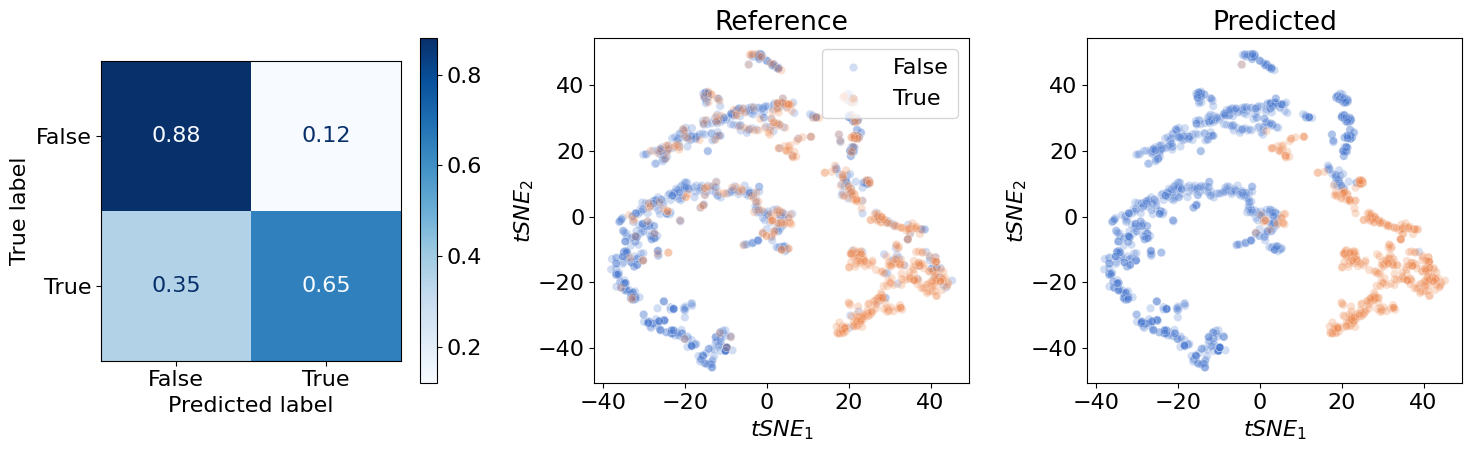

In [25]:
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1)).astype('bool')
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1)).astype('bool')
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'][dbresults['testidx']].argmax(axis=-1).tolist()
y_classes = dbresults['y_cls'][dbresults['testidx']].argmax(axis=-1)
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'][dbresults['testidx']], dbresults['pred_cls'][dbresults['testidx']])
print('binary acc:',np.sum(y_pclasses==y_classes)/len(y_pclasses))
print('AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)[:, np.newaxis],
                                            display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

dfr=dfr.sort_values(by=['y'])
sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr,alpha=0.25,palette = 'muted')#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
dfr=dfr.sort_values(by=['yp'])
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr,alpha=0.25,palette = 'muted')#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.savefig(mname+'_tsne.png',format='png',dpi=800,bbox_inches = "tight")
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
binary acc: 0.4007220216606498
AUC: 0.3981582


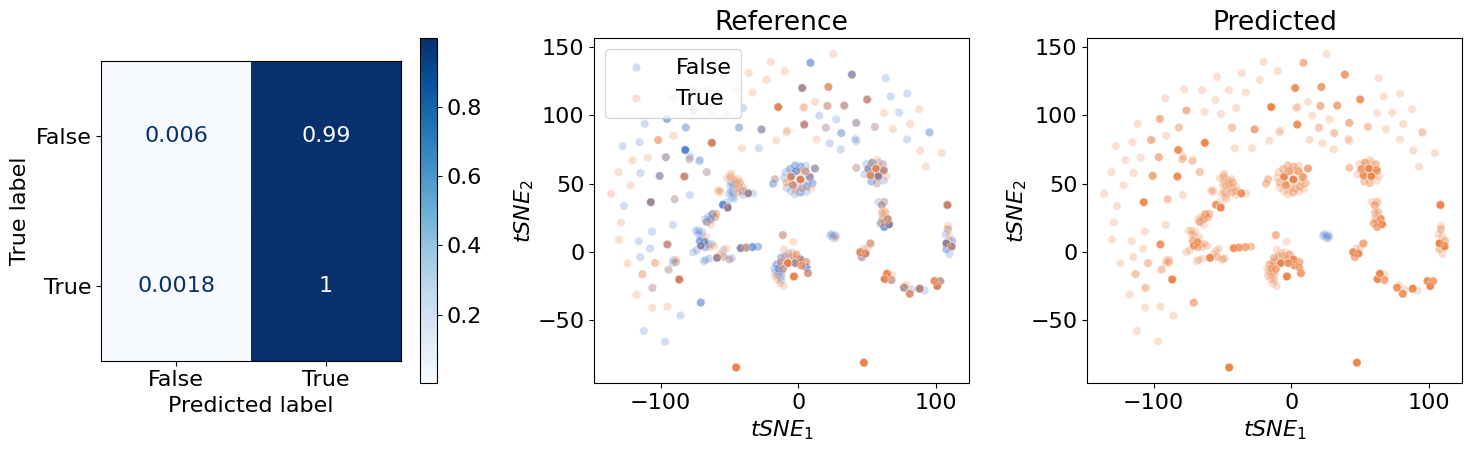

In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(extractorEmb.predict(x3_,batch_size = config.BATCH_SIZE))
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1)).astype('bool')
dfr["yp"] = np.asarray(dbresults['pred_clsV0'].argmax(axis=-1)).astype('bool')
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_clsV0'].argmax(axis=-1).tolist()
y_classes = dbresults['y_cls'].argmax(axis=-1)
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'], dbresults['pred_clsV0'])
print('binary acc:',np.sum(y_pclasses==y_classes)/len(y_pclasses))
print('AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)[:, np.newaxis],
                                            display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

dfr=dfr.sort_values(by=['y'])
sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr,alpha=0.25,palette = 'muted')#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
dfr=dfr.sort_values(by=['yp'])
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr,alpha=0.25,palette = 'muted')#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.savefig(mname+'_tsneV0.png',format='png',dpi=800,bbox_inches = "tight")
plt.show()